<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/flexible_link8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PyDrake Setup**

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

!pip install recordclass

Cloning into '/opt/underactuated'...

HEAD is now at 15cfd96 and again

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.




     |████████████████████████████████| 163kB 4.3MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344687 sha256=ec1c9d41145d983b4e84126eda410b8ef0fce632d94d1949b796caefc8144367
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass


###setup meshcat server

In [2]:
server_args = ['--ngrok_http_tunnel']

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

#**import modules**

In [3]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count


from pydrake.all import (
    DiagramBuilder, SceneGraph, Simulator, RigidTransform, 
    AddMultibodyPlantSceneGraph, Parser, RotationMatrix, PlanarSceneGraphVisualizer,
    LeafSystem, BasicVector, RevoluteSpring, AddTriad, RollPitchYaw
)

import pydrake.systems.meshcat_visualizer as meshcat_visualizer

#**URDF**

In [4]:
!pip install xacro

  Created wheel for xacro: filename=xacro-1.13.3-cp37-none-any.whl size=19524 sha256=217f99679a2137900f9684b18d7e358601cfcaf82caf81227fe5bd071b7dcc92
  Stored in directory: /root/.cache/pip/wheels/01/e9/16/490f9278bc8be9b28833b08ce491f53880229b7d07891af76d
Successfully built xacro


In [5]:
%%file model
<?xml version="1.0"?>

<robot xmlns:xacro="http://www.ros.org/wiki/xacro" name="RR">

  <xacro:macro name="Link" params="id damping color">
  <link name="link${id}">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="0.25" />
      <inertia ixx="0.125" ixy="0" ixz="0" iyy="0.125" iyz="0" izz="0.125" />
    </inertial>
    <visual>
      <origin xyz="0.125 0 0" rpy="0 0 0" />
      <geometry>
        <box size="0.25 0.1 0.05"/>
      </geometry>
      <material>
        <color rgba="${color} 1" />
      </material>
    </visual>
    <collision>
    <origin xyz="0.125 0 0" rpy="0 0 0" />
      <geometry>
        <box size="0.22 0.1 0.05"/>
      </geometry>
    </collision>
  </link>

  <joint name="theta${id}" type="continuous">
    <parent link="link${id-1}" />
    <child link="link${id}" />
    <origin rpy="0 0 0" xyz="0.25 0 0" />
    <axis xyz="0 0 1" />
    <dynamics damping="${damping}" />
  </joint>

  </xacro:macro>

  <link name="link0">
    <visual>
      <origin xyz="0.25 0 -0.25" rpy="0 0 0" />
      <geometry>
        <cylinder length=".1" radius=".053"  />
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>
  </link>

  <joint name="fixed1" type="fixed">
    <parent link="world" />
    <child link="link0" />
  </joint>

  <xacro:Link id = "1" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "2" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "3" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "4" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "5" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "6" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "7" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "8" damping = "0.1" color = "0.9 0.3 0.2"/>

  <transmission type="SimpleTransmission" name="j1">
    <actuator name="torque1" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot>

Writing model


In [6]:
!xacro model -o model.urdf

No module named 'rosgraph'



#Flexible Env class based on pydrake simulator

* joint damping coeff: 1 N.m.s

* joint stiffness: 5 N/m

In [33]:
def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)/np.pi

class FlexibleEnv():

  def __init__(self):
    self.Setup()
    self.reset()

  def Setup(self, visualize = False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parse_ins = Parser(plant).AddModelFromFile('./model.urdf')
    #Add Revolute spring
    for i in range(2,9):
      plant.AddForceElement(RevoluteSpring(plant.GetJointByName(f"theta{i}", parse_ins), 0, 5))
    plant.Finalize()
    self.plant = plant
    self.contactRes = plant.get_contact_results_output_port()
    self.scene_graph = scene_graph

    # Setup visualization
    self.visualizer = None
    if visualize:
      self.visualizer = meshcat_visualizer.ConnectMeshcatVisualizer(
                builder, 
                scene_graph = scene_graph, 
                zmq_url = zmq_url, 
                delete_prefix_on_load=True)
      #set planar view instead of 3d view
      self.visualizer.set_planar_viewpoint(camera_position=[0, 0, 1], 
                                  xmin=-3, xmax=1, ymin=-2, ymax=2)
    
    self.diagram = builder.Build()


  def reset(self, init_state = None):
    #reset time and simulator
    self.time = 0
    self.context = self.diagram.CreateDefaultContext()
    self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.simulator = Simulator(self.diagram, self.context)
    #set initial state
    self.set_state(init_state)
    return self.get_state
  
  def set_state(self, init_state = None):
    if not init_state:
      init_state = np.random.uniform(-1,1,4)
      init_state = init_state * [np.pi, 1, np.pi/6, 0.1]
    init_state = [init_state[0]] + [init_state[1]/3]*7 + [init_state[2]] + [init_state[3]/3]*7
    self.plant_context.SetContinuousState(init_state)

  @property
  def get_state(self):
    #get current state from plant
    state = self.plant.get_state_output_port().Eval(self.plant_context)
    state[0] = angle_normalize(state[0])
    return state
  

  def step(self, u, dt = 0.05):
    #Set joint torque with input
    self.plant.get_actuation_input_port().FixValue(self.plant_context, u)
    #Advance to next step
    self.simulator.AdvanceTo(self.time + dt)
    self.time += dt
    #return current state
    # num_contacts = self.contactRes.Eval(self.plant_context).num_point_pair_contacts()
    return self.get_state
  
  
  def start_recording(self, init_state = None):
    self.Setup(True)
    self.reset(init_state)
    self.visualizer.load()
    self.visualizer.start_recording()
  
  def stop_recording(self):
    self.visualizer.stop_recording()
    self.visualizer.publish_recording()

  def render(self, model, init_state = None):
    self.start_recording(init_state)
    
    for i in range(200):
      u = model(self.get_state)
      self.step(u)
    
    self.stop_recording()


##**Test Env**

In [34]:
env = FlexibleEnv()

In [35]:
env.reset([-np.pi/4,0,0,0])

array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [36]:
env.get_state

array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

##Apply constant torque

In [37]:
def model(state):
  return [1]
  
env.render(model)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://af83ec6b3ce8.ngrok.io/static/
Connected to meshcat-server.


#Import Torch

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

##Util to Plot reward


In [39]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

#Sparse Reward

In [40]:
def Reward(states, goal_states, epsilon):  

  dist = (states[:,0] - goal_states[:,0])**2
  dist += (states[:,2] - goal_states[:,2])**2
  dist = dist**(0.5)

  #reward is 0 if dist < epsilon, -1 if dist > epsilon
  rewards = -(dist > epsilon).float()
  return rewards.unsqueeze(1)

###Memory for [HindSight Experience Replay](https://arxiv.org/pdf/1707.01495.pdf)

In [41]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'goal_states', 'actions', 'next_states'))

class ReplayMemory():
    def __init__(self, capacity = 1000, state_dim = 16, goal_dim = 16, action_dim = 1, Her_k = 8):
      
        self.length = 0
        self.prev_length = 0
        self.capacity = capacity
        self.Her_K = Her_k

        self.states = np.zeros((capacity, state_dim))
        self.goal_states = np.zeros((capacity, Her_k, goal_dim))
        self.actions = np.zeros((capacity, action_dim))
        self.next_states = np.zeros((capacity, state_dim))

        self.temp_states = []
      
    def add_transition(self, *args):
        index = self.length % self.capacity

        self.temp_states.append(args[0])

        self.states[index] = args[0]
        self.goal_states[index][0] = args[1]
        self.actions[index] = args[2]
        self.next_states[index] = args[3]

        self.length += 1
    
    def add_goal_states(self):
        n = len(self.temp_states)
        temp_states = np.array(self.temp_states)
        self.temp_states = []
        for i in range(n):
          start = i if (n-i) > self.Her_K else n - self.Her_K

          goal_inds = np.random.randint(start,n,self.Her_K-1)

          ind = self.prev_length % self.capacity
          self.goal_states[ind][1:,:] = temp_states[goal_inds]
          self.prev_length += 1
        

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)
        goal_inds = np.random.choice(self.Her_K, batch_size)

        batch = Transitions(self.states[inds],
                            self.goal_states[inds,goal_inds],
                            self.actions[inds],
                            self.next_states[inds])
        
        for i in range(4):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
        
    def __len__(self):
      return min(self.length, self.capacity)

#**Q-value Network**

In [42]:
class DQN(nn.Module):

    def __init__(self, state_dim = 16, goal_dim = 16, action_dim = 1):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 32)
        self.l11.weight.data.uniform_(-0.05,0.05)
        self.l11.bias.data.fill_(0.01)

        self.l12 = nn.Linear(goal_dim, 32)
        self.l12.weight.data.uniform_(-0.05,0.05)
        self.l12.bias.data.fill_(0.01)

        self.l13 = nn.Linear(action_dim, 16)
        self.l13.weight.data.uniform_(-0.05,0.05)
        self.l13.bias.data.fill_(0.01)

        self.l2 = nn.Linear(80, 256)

        self.l3 = nn.Linear(256, 1)
        self.l3.weight.data.uniform_(-0.003,0.003)
        self.l3.bias.data.fill_(0.001)

    def forward(self, states, goal_states, actions):
        states = torch.tanh(self.l11(states))
        goal_states = torch.tanh(self.l12(goal_states))
        actions = torch.tanh(self.l13(actions))
        x = torch.cat((states, goal_states, actions),1)
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x


#**Double DQN critic** 

In [43]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.q1 = DQN()
    self.q2 = DQN()
  
  def predict(self, states, goal_states, actions):
    q1 = self.q1(states, goal_states, actions)
    q2 = self.q2(states, goal_states, actions)
    return q1, q2
  
  def forward(self, states, goal_states, actions):
    q1, q2 = self.predict(states, goal_states, actions)
    return torch.min(q1, q2)
  
  def Cal_loss(self, expected_critic_values, batch):
    q1, q2 = self.predict(batch.states, batch.goal_states, batch.actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2

#**Policy network**

In [44]:
class Policy(nn.Module):

    def __init__(self, state_dim = 16, goal_dim = 16, action_dim = 1, action_limit = 4):
        super(Policy, self).__init__()

        self.act_lim = action_limit

        self.l11 = nn.Linear(state_dim, 32)
        self.l11.weight.data.uniform_(-0.05,0.05)
        self.l11.bias.data.fill_(0.01)

        self.l12 = nn.Linear(goal_dim, 32)
        self.l12.weight.data.uniform_(-0.05,0.05)
        self.l12.bias.data.fill_(0.01)

        self.l2 = nn.Linear(64, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.01,0.01)
        self.mean_layer.bias.data.fill_(0.01)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.005,0.005)
        self.log_std.bias.data.fill_(0.005)


    def forward(self, states, goal_states, training = True):
        states = torch.tanh(self.l11(states))
        goal_states = torch.tanh(self.l12(goal_states))

        x = torch.cat((states, goal_states), 1)
        x = torch.relu(self.l2(x))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        if not training:
          sample = mean
        else:
          sample = mean + std * torch.randn(mean.size())

        action = torch.tanh(sample)
        log_probs = Normal(mean, std).log_prob(sample) - torch.log(1 - action**2 + 1e-8)

        return self.act_lim * action, std, log_probs


    def choose_action(self, state, goal_state, training = True, verb = 0):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        goal_state = torch.tensor(goal_state, dtype = torch.float).unsqueeze(0)

        action, std, _  = self.forward(state, goal_state, training)
        action, std = action.item(), std.item()
        if verb: print(action, std)
        
        return [round(action, 5)]
        

##Traininig utils

In [45]:
def Optimize(model, optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1) 
        # param.grad.data[torch.isnan(param.grad.data)] = 0
    optimizer.step()

In [46]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

#**Initialize**

In [58]:
gamma = 0.99     # discount factor
epsilon = 0.075  # distance threshold
alpha = 0.1      # entropy reward coeff

actor = Policy().to(device)
critic = Critic().to(device)

target_actor = Policy().to(device)
target_actor.load_state_dict(actor.state_dict())

target_critic = Critic().to(device)
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(),1e-3)
critic_optimizer = optim.Adam(critic.parameters(),1e-3)

memory = ReplayMemory(300000)

reward_list = []
avg_rewards = []

#**Single training step**

In [59]:
def train_step():
    if len(memory) < 2000: return

    batch = memory.sample(64)

  #---------------------critic training----------------------------------
    next_actions, std, log_probs = actor(batch.next_states, batch.goal_states)
    next_critic_values = target_critic(batch.next_states, batch.goal_states, next_actions).detach()

    expected_critic_values = Reward(batch.states, batch.goal_states, epsilon) + gamma *(next_critic_values - alpha*log_probs)
    expected_critic_values = expected_critic_values.clamp(-150, 150)

    critic_loss = critic.Cal_loss(expected_critic_values.detach(), batch)

    Optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


  #-----------------Freeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = False
  #------------------------------------------------------------------------


  #---------------------actor training----------------------------------
    actions, std, log_probs = actor(batch.states, batch.goal_states)
    critic_value = critic(batch.states, batch.goal_states, actions)
    actor_loss = torch.mean(-critic_value + alpha*log_probs)

    Optimize(actor, actor_optimizer, actor_loss)
  #-----------------------------------------------------------------------


  #--------------------UnFreeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = True
  #-------------------------------------------------------------------------


  #----------------soft update targets--------------------------------------
    soft_update(target_actor, actor, 0.005)
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

#**Training**

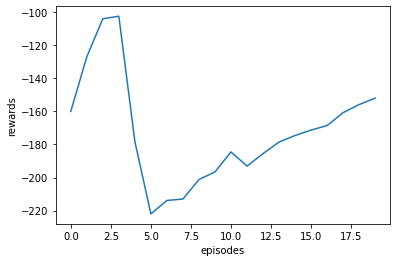



100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


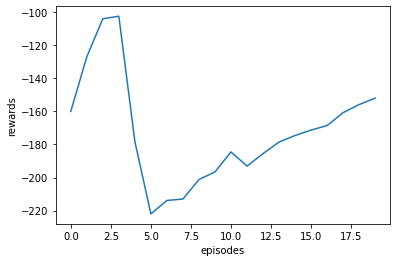

In [63]:
env = FlexibleEnv()

for i_episode in tqdm(range(20)):

  state = env.reset()
  total_reward = 0
  goal_state = [np.random.uniform(-1,1)]+[0]*15

  print(state, goal_state)

  for steps in range(500):

    action = actor.choose_action(state, goal_state)
    next_state = env.step(action)
    memory.add_transition(state, goal_state, action[0], next_state)


    dist = ((state[0] - goal_state[0])**2 + (state[2] - goal_state[2])**2)**(0.5)
    dist = -int(dist > epsilon)
    total_reward += dist

    state = next_state
  
  memory.add_goal_states()
  for _ in range(300):   
    train_step()

  reward_list.append(total_reward)
  avg_rewards.append(np.mean(reward_list[-40:])) 

  plot(avg_rewards[-100:])

In [ ]:
torch.save({
          'actor': target_actor.state_dict(),
          'critic': target_critic.state_dict(),
          'actor_optimizer': actor_optimizer.state_dict(),
          'critic_optimizer': critic_optimizer.state_dict()
          }, 'best2')


In [50]:
from google.colab import files
files.upload()

Saving best (3) to best (3)


{'best (3)': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x12\x00archive/data.pklFB\x0e\x00ZZZZZZZZZZZZZZ\x80\x02}q\x00(X\x05\x00\x00\x00actorq\x01ccollections\nOrderedDict\nq\x02)Rq\x03(X\n\x00\x00\x00l11.weightq\x04ctorch._utils\n_rebuild_tensor_v2\nq\x05((X\x07\x00\x00\x00storageq\x06ctorch\nFloatStorage\nq\x07X\x0e\x00\x00\x0094360921944688q\x08X\x03\x00\x00\x00cpuq\tM\x00\x02tq\nQK\x00K K\x10\x86q\x0bK\x10K\x01\x86q\x0c\x89h\x02)Rq\rtq\x0eRq\x0fX\x08\x00\x00\x00l11.biasq\x10h\x05((h\x06h\x07X\x0e\x00\x00\x0094360923522544q\x11h\tK tq\x12QK\x00K \x85q\x13K\x01\x85q\x14\x89h\x02)Rq\x15tq\x16Rq\x17X\n\x00\x00\x00l12.weightq\x18h\x05((h\x06h\x07X\x0e\x00\x00\x0094360505610832q\x19h\tM\x00\x02tq\x1aQK\x00K K\x10\x86q\x1bK\x10K\x01\x86q\x1c\x89h\x02)Rq\x1dtq\x1eRq\x1fX\x08\x00\x00\x00l12.biasq h\x05((h\x06h\x07X\x0e\x00\x00\x0094360923093808q!h\tK tq"QK\x00K \x85q#K\x01\x85q$\x89h\x02)Rq%tq&Rq\'X\t\x00\x00\x00l2.weightq(h\x

In [61]:
state = torch.load('best (3)')

In [62]:
actor.load_state_dict(state['actor'])
critic.load_state_dict(state['critic'])
actor_optimizer.load_state_dict(state['actor_optimizer'])
critic_optimizer.load_state_dict(state['critic_optimizer'])

#Test Learned Policy

In [ ]:
def Go_to(goal = np.pi/2, init_state = None, verb = 0):

  goal_state = [goal/np.pi]+[0]*15

  policy = lambda state: target_actor.choose_action(state, goal_state, False, verb)

  #Simulate with learned policy
  env = FlexibleEnv()
  env.start_recording(init_state)

  us = []
  prev_theta = 0

  for i in range(400):
      u = policy(env.get_state)
      us.append(u[0])
      state = env.step(u)
    
  env.stop_recording()
  plt.plot(us[:75])


  #Add target angle Marker in visualiser
  R = RollPitchYaw([np.pi/4, 0, goal])
  T = RigidTransform(R, [0.25,0,0]).GetAsMatrix4()
  AddTriad(env.visualizer.vis, name='target', prefix='', length=1, radius=0.01, opacity=0.8)
  env.visualizer.vis['']['target'].set_transform(T)

In [ ]:
Go_to(np.pi/2, [-np.pi/2,0,0,0], 0)

# env.get_state